In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, log_loss

import librosa

import pickle

from song_splitter import audio_framer

In [2]:
# Reading in track metadata
tracks = pd.read_csv('../data/tracks_meta.csv', index_col = 0)

For the purposes of this approach to modeling and for the subsequent recommender system, we'll be using the time-aggregated approach as described in the EDA notebook. The basic idea is to split each song into consecutive segments (10 by default) then take the average and standard deviation of the mel bands across that segment and use the ten segments as our representation of each song. This will allow us to attempt traditional classification methods and later to calculate similarities between the larger time-segments. The exact code used here can be found in [song_splitter.py](./song_splitter.py).

In [3]:
# Initialize a dataframe to hold our song data
agg_songs = pd.DataFrame(None, columns = ['song_index', 'ts'] + list(range(256)))

# Read in each song, split them into segments and add them to the dataframe
for idx in tracks.index:
    agg_songs = pd.concat([agg_songs, audio_framer(np.load('D:/GA-DSI/capstone-data/audio/' + str(idx) + '.npy'), idx)])


# Merge our track data with the aggregated audio data
merged = pd.merge(
    left = tracks,
    right = agg_songs,
    how = 'inner',
    left_index = True,
    right_on = 'song_index'
).reset_index()

In [4]:
# Training split is provided
X_train = merged[merged['split'] == 'training'][list(range(256))]
# Combined test and validation splits for this approach
X_test = merged[merged['split'] != 'training'][list(range(256))]

# Mapping each genre to a number
map_genre = {
    'Hip-Hop': 0,
    'Pop' : 1,
    'Folk' : 2,
    'Rock' : 3,
    'Experimental' : 4,
    'International' : 5,
    'Electronic' : 6,
    'Instrumental' : 7
}

# Creating response arrays
y_train = merged[merged['split'] == 'training']['genre_top'].map(map_genre)
y_test = merged[merged['split'] != 'training']['genre_top'].map(map_genre)

In [23]:
merged[merged['split'] == 'training']['genre_top'].value_counts(normalize = True) # Approximately 0.125 baseline accuracy

Pop              0.125117
Folk             0.125117
International    0.125117
Instrumental     0.125117
Rock             0.124961
Experimental     0.124961
Electronic       0.124961
Hip-Hop          0.124648
Name: genre_top, dtype: float64

[Principal Component Analysis (PCA)](https://royalsocietypublishing.org/doi/10.1098/rsta.2015.0202) was mentioned before but before we apply it in earnest let's take a moment to cover what it is and why we believe its a valuable tool for our purposes. PCA is a technique often applied to reduce the number of dimensions in a dataset while minimizing how much information is lost. In essence, PCA creates a representation of your original data with the exact same dimensions where each column of the transformed data is a principal component of the original data. These principal components are linear transformations of the original columns in the data with two key properties. First, each principal component is orthogonal to all other components (principal components are decorrelated). Secondly, each successive principal component explains less of the variance in our original data than the one before. This allows us to decide how many principal components we want to use based on what percentage of the variance in our original data those principal components explain. In practice, we apply PCA to our data and plot the proportion of variance explained by each successive component and then we select a cutoff based on where adding more components has only a small increase in how much more variance is explained. Below we will go through the process of determining how many principal components we will include for our final model. 

In [5]:
# No limit to components to decide our cutoff
pipe = Pipeline(
    [
        # Standard Scaler because MinMax scaler had very slightly worse separation
        ('ss', StandardScaler()),
        ('pca', PCA())
    ]
).fit(X_train)

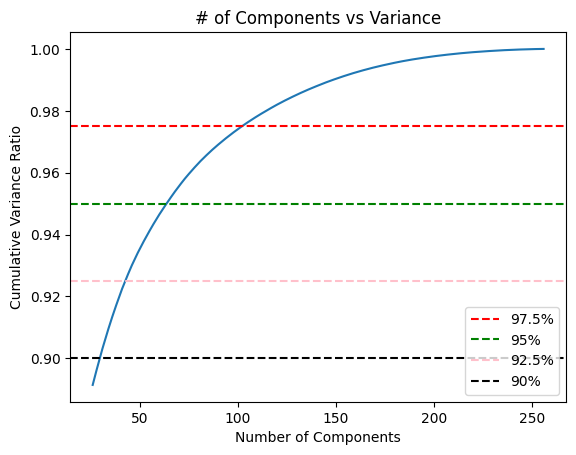

In [6]:
# Plotting cumulative variance to identify a cutoff value

sns.lineplot(
    x = range(26, 257),
    y = np.cumsum(pipe['pca'].explained_variance_ratio_)[25:]
    )

# 85% is omitted because it's before the 'elbow', normally 85% is the default cutoff
plt.axhline(0.975, linestyle = '--', color = 'red', label = '97.5%')
plt.axhline(0.95, linestyle = '--', color = 'green', label = '95%')
plt.axhline(0.925, linestyle = '--', color = 'pink', label = '92.5%')
plt.axhline(0.9, linestyle = '--', color = 'black', label = '90%')


plt.legend(loc = 'lower right')
plt.ylabel('Cumulative Variance Ratio')
plt.xlabel('Number of Components')
plt.title('# of Components vs Variance');

We're going to proceed with the first 100 components, ideally we'd take more but we don't want our similarity matrix down the line to be too computationally expensive and we'd like to save the transformed dataframe and pre-processing pipe later for use in an app so we'll take a (slightly) more conservative approach here. 

Let's take a moment here to ensure we're happy with how our decomposition is separating our data. To assess this, we'll take a look at the two songs we compared in [EDA](./02-EDA.ipynb) which had very different spectograms. If our model is working effectively, we know that our separation is working well at least in the more extreme cases.

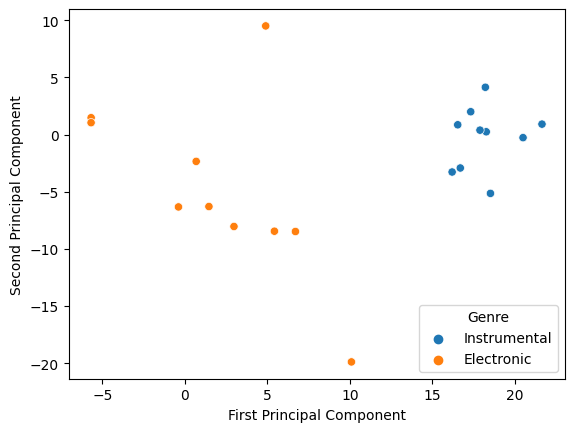

In [7]:
# Same function as EDA notebook
def get_path(index):
    PATH = "D:/GA-DSI/capstone-data/fma_small/"
    padded_index = '0'*6 + str(index) + '.mp3'
    path = PATH + padded_index[-10:-7] + '/' + padded_index[-10:]

    return path

# Same seed as EDA notebook
np.random.seed(42)

instr_song = tracks[tracks['name'] == 'Blue Dot Sessions'].sample(1)
song, sr = librosa.load(get_path(instr_song.index[0]))
# Removing reference np.max for default of 1 to match the data used for this model
instr_mel = librosa.power_to_db(librosa.feature.melspectrogram(y = song, sr = sr)) 

elec_song = tracks[tracks['genre_top'] == 'Electronic'].sample(1) 
song, sr = librosa.load(get_path(elec_song.index[0]))
elec_mel = librosa.power_to_db(librosa.feature.melspectrogram(y = song, sr = sr))

example_songs = pd.DataFrame(None, columns = ['song_index', 'ts'] + list(range(256)))

for idx in [instr_song.index[0], elec_song.index[0]]:
    example_songs = pd.concat(
        [
            example_songs, 
            audio_framer(np.load('D:/GA-DSI/capstone-data/audio/' + str(idx) + '.npy'), idx)
        ]
    )

# To keep the song_index column for our plot
decomp_songs = pd.concat(
    [
        example_songs.loc[:, 'song_index'],
        pd.DataFrame(pipe.transform(example_songs.loc[:, range(256)]), index = example_songs.index)
    ],
    axis = 1
)

sns.scatterplot(
    x = decomp_songs[0],
    y = decomp_songs[1],
    hue = decomp_songs['song_index'].map(
        {   # Manually mapping songs to their genre
            92548 : 'Electronic',
            127661 : 'Instrumental'
        }
    )
)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend(loc = 'lower right', title = 'Genre');

That's a striking difference, even in just the first two dimensions we can see clear separation between the songs and that our instrumental song is much more densely clumped together than our electronic song. Now, this is only two out of a hundred dimensions that we'll be using but this is a promising sign. Let's take a look at how we do across every song and genre.

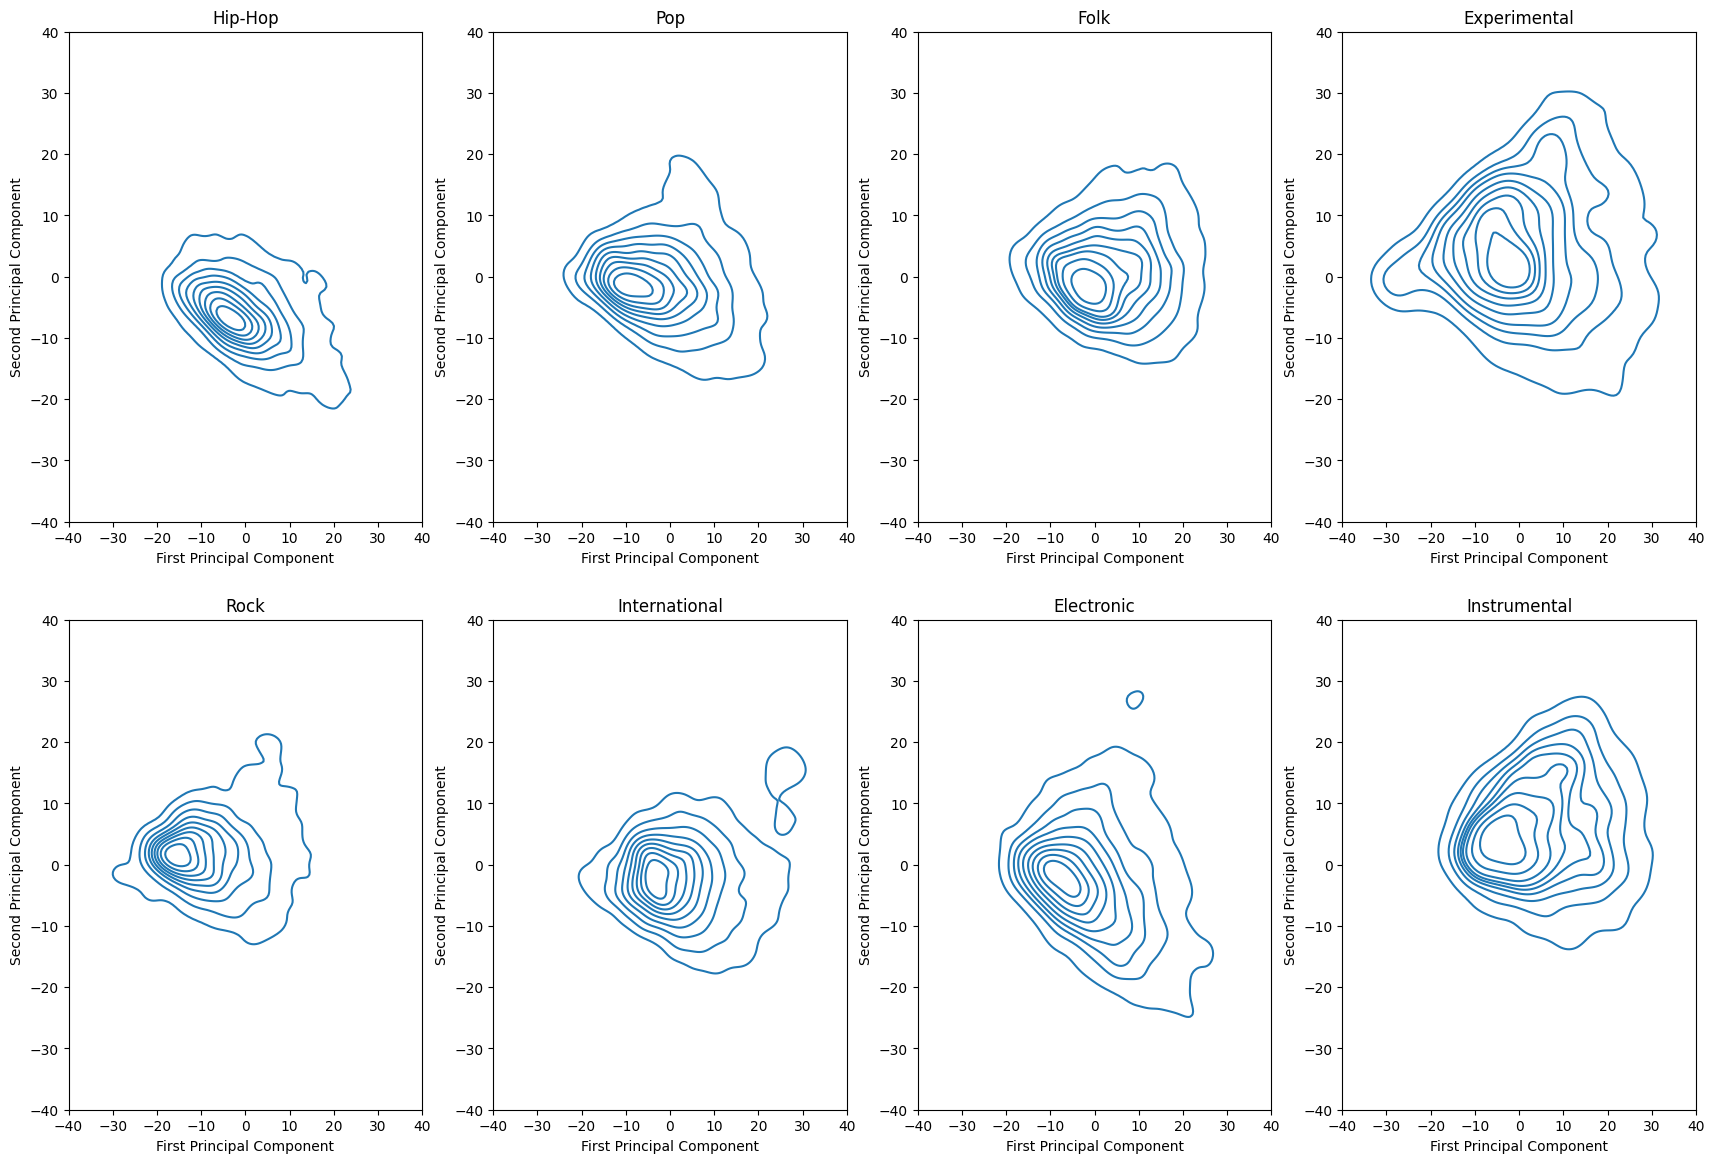

In [8]:
# Merging genre with decomposed audio data
decomped_df = pd.concat(
    [
        merged.loc[:, 'genre_top'],
        pd.DataFrame(pipe.transform(merged.loc[:, range(256)]), index = merged.index)
    ],
    axis = 1
)

# Defining shared bounds for each plot
x_min, y_min, x_max, y_max = -40, -40, 40, 40

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize = (21, 14))

# Iterate through each genre and an associated subplot
for key, axis in zip(merged['genre_top'].unique(), ax.flatten()):
    # Plot density distribution of first two principal components for each genre
    sns.kdeplot(
        x = decomped_df[decomped_df['genre_top'] == key][0],
        y = decomped_df[decomped_df['genre_top'] == key][1],
        ax = axis
    )
    
    axis.set_xlabel('First Principal Component')
    axis.set_xlim(x_min, x_max)

    axis.set_ylabel('Second Principal Component')
    axis.set_ylim(y_min, y_max)

    axis.set_title(key);

This is probably the clearest representation of our genres so far. We can see the shape and location of the distribution of each genre in the first two dimensions. Most notable here is the overlap between the genres. Many genres are clumped around the origin which isn't surprising given we're only plotting across the first two components and we've identified the first 100 as worth including in our model. We can also see that different genres have differently shaped distributions across these dimensions. In particular, Hip-Hop is a very dense genre while Experimental is our most spread out genre. This makes intuitive sense given that Experimental is a genre about, well, experimentation. The genre has a wide array of ideas and would logically overlap with a number of other songs in other genres. All in all, incredibly interesting to see these genres from this angle but unfortunately the overlap is somewhat worrying for our classification hopes. Though, high inter-genre overlap could be a good sign for finding novel song recommendations later on.

The model we've chosen is LightGBM which is a tree-based gradient boosting model designed to be quicker to train and less memory intensive than other gradient boosting models such as the ever-popular XGBoost. LightGBM does have some downsides, in particular a slightly higher tendency to overfitting a quick overview of the pros and cons of the two models can be found [here](https://medium.com/@rithpansanga/evaluating-the-trade-offs-between-xgboost-and-lightgbm-c1b17fdc4f5e). Let's take a quick look at how well an untuned model does with our established decomposition method.

In [9]:
# Testing classification with our cutoff
pipe = Pipeline(
    [
        ('ss', StandardScaler()),
        ('pca', PCA(n_components = 100)),
        ('lgb', LGBMClassifier(random_state = 42, n_jobs = 4, verbose = -100))
    ]
)

pipe.fit(X_train, y_train)

print('Train Score:', round(pipe.score(X_train, y_train), 4))
print('Test Score:', round(pipe.score(X_test, y_test), 4))

Train Score: 0.7697
Test Score: 0.4199


Compared to our neural network approach we've doubled our test accuracy with a fraction of the time spent training our model so clearly this approach has some serious merit. We still don't have stellar accuracy but as we saw with the density plots above, there is just a lot of genre to genre overlap in our data using this approach. This could tell us that genres are more similar than they are different or, more likely, this could be a shortcoming of our aggregation approach. 

Before moving on, let's consider using a large number of splits per song to see if that helps or hurts our approach.

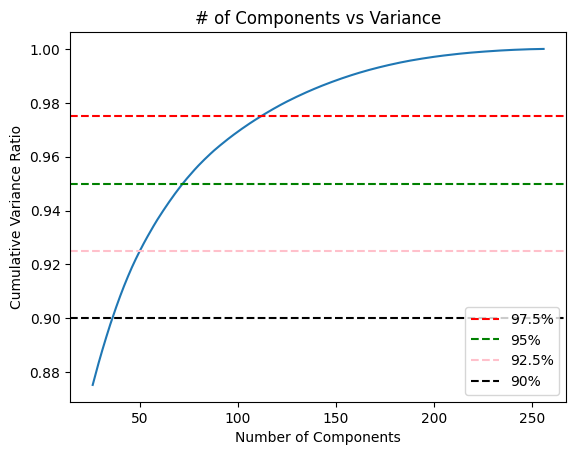

In [10]:
# Recreated from above to test 20 segments instead of 10

# Initialize a dataframe to hold our song data
agg_songs = pd.DataFrame(None, columns = ['song_index', 'ts'] + list(range(256)))

# Read in each song, split them into segments and add them to the dataframe
for idx in tracks.index:
    agg_songs = pd.concat([agg_songs, audio_framer(np.load('D:/GA-DSI/capstone-data/audio/' + str(idx) + '.npy'), idx, 20)]) # 1.5s intervals instead of 3s


# Merge our track data with the aggregated audio data
merged = pd.merge(
    left = tracks,
    right = agg_songs,
    how = 'inner',
    left_index = True,
    right_on = 'song_index'
).reset_index()

# Training split is provided
X_train = merged[merged['split'] == 'training'][list(range(256))]
# Combined test and validation splits for this approach
X_test = merged[merged['split'] != 'training'][list(range(256))]

# Mapping each genre to a number
map_genre = {
    'Hip-Hop': 0,
    'Pop' : 1,
    'Folk' : 2,
    'Rock' : 3,
    'Experimental' : 4,
    'International' : 5,
    'Electronic' : 6,
    'Instrumental' : 7
}

# Creating response arrays
y_train = merged[merged['split'] == 'training']['genre_top'].map(map_genre)
y_test = merged[merged['split'] != 'training']['genre_top'].map(map_genre)

# No limit to components to decide our cutoff
pipe = Pipeline(
    [
        ('ss', StandardScaler()),
        ('pca', PCA())
    ]
).fit(X_train)

# Plotting cumulative variance to identify a cutoff value
sns.lineplot(
    x = range(26, 257),
    y = np.cumsum(pipe['pca'].explained_variance_ratio_)[25:]
    )

# 85% is omitted because it's before the 'elbow', normally 85% is the default cutoff
plt.axhline(0.975, linestyle = '--', color = 'red', label = '97.5%')
plt.axhline(0.95, linestyle = '--', color = 'green', label = '95%')
plt.axhline(0.925, linestyle = '--', color = 'pink', label = '92.5%')
plt.axhline(0.9, linestyle = '--', color = 'black', label = '90%')


plt.legend(loc = 'lower right')
plt.ylabel('Cumulative Variance Ratio')
plt.xlabel('Number of Components')
plt.title('# of Components vs Variance');

Interestingly, we actually have less cumulative variance explained at every number of components if we split songs into 20 segments instead of 10. This means, at the same number of components we've more or less gotten slightly worse results while also conveniently doubling the number of rows (and therefore amount of computation). Let's quickly check performance at the same number of components before we dismiss this out of hand though. This also suggests that we are losing meaningful information in our 10-segment representation because we need more columns to explain the same amount of variance with the 20-segment data. That isn't a surprising result, rather a completely expected one, but it is important to note.

In [11]:
# Applying same cutoff as for 10-segments
pipe = Pipeline(
    [
        ('ss', StandardScaler()),
        ('pca', PCA(n_components = 100)),
        ('lgb', LGBMClassifier(random_state = 42, n_jobs = 4, verbose = -100))
    ]
)

pipe.fit(X_train, y_train)

print('Train Score:', round(pipe.score(X_train, y_train), 4))
print('Test Score:', round(pipe.score(X_test, y_test), 4))

Train Score: 0.6662
Test Score: 0.4202


We actually get worse performance on our test set, granted only slightly. Our training set is also substantially less overfit which is not bad at all. We'll still proceed with the original 10-split approach for computational efficiency but there may actually be some merit to this more granular line of thought.

#### Model Tuning

Let's attempt to find a better model for the 10-segment data in the hopes of substantially increasing our accuracy or at least decreasing our overfit.

In [12]:
# Recreating the original 10-segment dataframe
# We overwrote the old one to not use too much memory

# Initialize a dataframe to hold our song data
agg_songs = pd.DataFrame(None, columns = ['song_index', 'ts'] + list(range(256)))

# Read in each song, split them into segments and add them to the dataframe
for idx in tracks.index:
    agg_songs = pd.concat([agg_songs, audio_framer(np.load('D:/GA-DSI/capstone-data/audio/' + str(idx) + '.npy'), idx)])


# Merge our track data with the aggregated audio data
merged = pd.merge(
    left = tracks,
    right = agg_songs,
    how = 'inner',
    left_index = True,
    right_on = 'song_index'
).reset_index()

# Training split is provided
X_train = merged[merged['split'] == 'training'][list(range(256))]
# Combined test and validation splits for this approach
X_test = merged[merged['split'] != 'training'][list(range(256))]

# Creating response arrays
y_train = merged[merged['split'] == 'training']['genre_top'].map(map_genre)
y_test = merged[merged['split'] != 'training']['genre_top'].map(map_genre)

preprocessing = Pipeline(
    [
        ('ss', StandardScaler()),
        ('pca', PCA(n_components = 100))
    ]
)

LightGBM has quite a large number of parameters many of which approach the same problems in different ways. A full overview of these parameters can be found in the [LightGBM documentation](https://lightgbm.readthedocs.io/en/stable/Parameters.html). For the purposes of this analysis and due to the sheer volume of parameters combined with the high model training time, we will only be tuning 3 parameters. These parameters were chosen mainly due to their simplicity and similarity to parameters from a number of other models. As we will see, tuning these parameters only had a small effect on our accuracy (though a reasonable reduction in overfitting) so while it is likely a better model can be found, the tangible benefits to finding that model are specious at best. Our data only measures the 'top genre' for each song so we shouldn't be too surprised that its quite difficult to separate our genres regardless of our model. 

In [13]:
lgbm_pipe = Pipeline(
    [
        ('pre', preprocessing),
        ('lgb', LGBMClassifier(random_state = 42, n_jobs = 4, verbose = -100))
    ]
)

params = {
    # The number of boosting rounds, more should increase accuracy but tend towards more overfit
    'lgb__n_estimators' : [75, 100, 150], 
    # L1 regression parameter, higher values will help fight overfitting
    'lgb__reg_alpha' : [0, 0.1, 1, 5],
    # L2 regression parameter, higher values will help fight overfitting
    'lgb__reg_lambda' : [0, 0.1, 1, 5]
}


lgbm_grid = GridSearchCV(
    lgbm_pipe,
    param_grid = params,
    cv = 5
).fit(X_train, y_train)


print('CV Score:', round(lgbm_grid.best_score_, 4))
print('Training Score:', round(lgbm_grid.score(X_train, y_train), 4))
print('Test Score:', round(lgbm_grid.score(X_test, y_test), 4))

CV Score: 0.4584
Training Score: 0.8285
Test Score: 0.4236


In [20]:
lgbm_grid.best_estimator_['lgb']

Pipeline(steps=[('pre',
                 Pipeline(steps=[('ss', StandardScaler()),
                                 ('pca', PCA(n_components=100))])),
                ('lgb',
                 LGBMClassifier(n_estimators=150, n_jobs=4, random_state=42,
                                reg_alpha=1, reg_lambda=0.1, verbose=-100))])

We have a fairly rudimentary attempt at tuning here, it takes about 30 minutes to check even just these parameters and it seems like we're going to want to use more predictors than the default 100. This will also increase train time. Additionally, our test accuracy hasn't shifted much and from earlier we know that there is a lot of inter-genre overlap within this approach to simplifying our data from the genre-density plots above. We also see a sharp increase in overfit which. For these reasons, we'll only try one more grid search and take the best model from there as our best model and move on to our recommender system which is the core product this whole project was meant to build towards in the first place. 

In [15]:
lgbm_pipe = Pipeline(
    [
        ('pre', preprocessing),
        ('lgb', LGBMClassifier(random_state = 42, n_jobs = 4, verbose = -100))
    ]
)

params = {
    'lgb__n_estimators' : [125, 150, 175, 200],
    'lgb__reg_alpha' : [0.5, 1, 1.5],
    'lgb__reg_lambda' : [0.2, 0.1, 0.15, 0.05]
}


lgbm_grid = GridSearchCV(
    lgbm_pipe,
    param_grid = params,
    cv = 5
).fit(X_train, y_train)

print('CV Score:', round(lgbm_grid.best_score_, 4))
print('Training Score:', round(lgbm_grid.score(X_train, y_train), 4))
print('Test Score:', round(lgbm_grid.score(X_test, y_test), 4))

CV Score: 0.4582
Training Score: 0.8579
Test Score: 0.4223


Again, tuning isn't particularly helping us here. We aren't taking the most comprehensive approach to tuning here but in the end, our model is doing much better than our attempt at CNNs did. We can take a quick look at our best parameters and then evaluate our performance across the different genres to get an idea where we're going wrong. 

In [16]:
lgbm_grid.best_estimator_['lgb']

LGBMClassifier(n_estimators=175, n_jobs=4, random_state=42, reg_alpha=1,
               reg_lambda=0.05, verbose=-100)

Like before, we see more estimators is better. Additionally, stronger regularization with alpha (L1) than lambda (L2) seems to perform slightly better. Generally, we're seeing that we do have avenues to tune further but we have fair reason to expect that we won't gain a lot of accuracy here. We've only really gained half a percent of accuracy and we know our data isn't very separable so we can comfortably conclude this avenue has at least closed in on its peak accuracy. Before we move on though, let's assess performance.

#### Model Evaluation

In [17]:
# Retraining LGBM with best parameters
lgbm_pipe = Pipeline(
    [
        ('pre', preprocessing),
        ('lgb', LGBMClassifier(
            n_estimators = 200,
            reg_alpha = 1.5,
            reg_lambda = 0.1,
            random_state = 42, 
            n_jobs = 4, 
            verbose = -100))
    ]
).fit(X_train, y_train)

In [18]:
genre_map = {key : value for key, value in zip(map_genre.values(), map_genre.keys())}

predictions = pd.Series(lgbm_pipe.predict(X_test)).map(genre_map)

predictions.value_counts()

Experimental     2302
Electronic       2224
Hip-Hop          2179
Folk             2106
Instrumental     1834
Pop              1827
International    1766
Rock             1762
dtype: int64

Surprisingly, we actually have a decently even distribution of predictions, it's a shame that we aren't particularly accurate. We'd expect exactly 2000 observations in each rows given our even test split. We see Experimental the most commonly predicted genre which makes sense because as we noted there was a huge amount of spread in the first two principal components as we saw with our density plots earlier. Let's take a look at our prediction distribution for each genre, that is for all the song-segments in each genre what was the distribution of predicted genre. Ideally, for each genre our most commonly predicted genre will be the true genre but given our low accuracy we can expect different results.

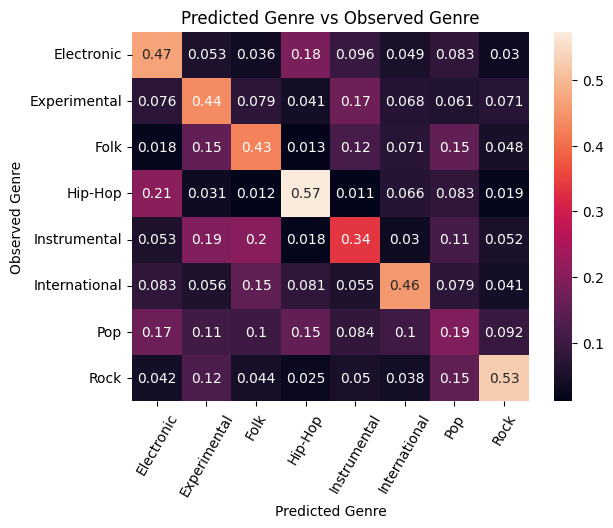

In [19]:
genre_preds = []

for genre in sorted(map_genre.keys()):
    sub_indices = merged[(merged['genre_top'] == genre) & (merged['split'] != 'training')].index
    genre_preds.append(
        pd.Series(
            lgbm_pipe.predict(X_test.loc[sub_indices, : ])
            ).map(genre_map).value_counts(normalize = True).sort_index()
    )

prediction_matrix = pd.DataFrame(genre_preds, index = sorted(map_genre.keys()))

sns.heatmap(prediction_matrix, annot = True)

plt.xticks(rotation = 60)

plt.xlabel('Predicted Genre')
plt.ylabel('Observed Genre')

plt.title('Predicted Genre vs Observed Genre');

There's quite a lot to take in here but first things first: outside of Pop and Instrumental, our model does okay at identifying genre for songs. More specifically, by far and away the most commonly predicted genre for songs outside of the Pop and Instrumental genre is the appropriate genre. Our accuracy is still not high but that's really a factor of how many categories we have to pick from so there are more ways to be wrong. For the Pop and Instrumental genres however, we see a much more even distribution of misclassification with Pop in particular having the lowest accuracy at only 19%. For Pop we see that our model misclassifies as Electronic and Hip-Hop quite often (17% and 15% respectively) which does make intuitive sense because those genres have a fair amount of overlap in reality. Electronic and Hip Hop have been popular genres for a while now and Pop is a genre that is often a blend of popular styles. 

Let's take a look at a few other metrics across genre:

In [20]:
print(classification_report(y_test.map(genre_map), predictions))

               precision    recall  f1-score   support

   Electronic       0.42      0.47      0.44      2000
 Experimental       0.38      0.44      0.41      2000
         Folk       0.41      0.43      0.42      2000
      Hip-Hop       0.53      0.57      0.55      2000
 Instrumental       0.37      0.34      0.35      2000
International       0.52      0.46      0.48      2000
          Pop       0.21      0.19      0.20      2000
         Rock       0.60      0.53      0.56      2000

     accuracy                           0.43     16000
    macro avg       0.43      0.43      0.43     16000
 weighted avg       0.43      0.43      0.43     16000



We don't see too much of interest here, mostly our model performs somewhat evenly within each genre. We have 3 genres (Electronic, Experimental, Hip-Hop) that have lower precision than recall and 1 genre with notably higher precision than recall (Rock), the remaining 5 genres are all about even between the two metrics. Electronic, Experimental, and Hip-Hop being similar here is quite interesting because we haven't particularly grouped those three genres before. Intuitively, they aren't particularly similar genres and we never saw too much similarity between them in our genre plots but here our model has similar behavior for them regardless. We should be careful to not read too much into this but it's an interesting result to take note of at least.


We know that our listed genre is only the top genre of each song and that songs can have a number of genres including other genres within our subset of 8 genres. So a Pop song can also be Electronic or Rock or even Folk. Let's take a look at a more standard loss metric to understand how confident our model is in its predictions across each genre. The hope here is that we can then identify which genres our model believes overlap a bit more with other genres.

In [21]:
y_test_multi = pd.get_dummies(merged[merged['split'] != 'training']['genre_top'])
log_loss(y_test_multi, lgbm_pipe.predict_proba(X_test))

2.6374515913927787

Log-Loss isn't an easy to interpret metric without a comparison point so we'll consider the validation loss from our Neural Network in the previous notebook. Our log-loss for our better model, even with a much lower accuracy, is actually a bit lower than we have here. This means that either our model is at times a bit overconfident in its incorrect predictions compared to the neural network or that our model is less confident in its correct predictions. For a simple way to investigate this, let's take the genre with the highest predicted probability and group that by whether a our prediction was correct, then compare the mean and variance of each group.

In [22]:
correct_indices   = y_test[y_test == predictions.map(map_genre).values].index
incorrect_indices = y_test[y_test != predictions.map(map_genre).values].index

correct_proba   = np.max(lgbm_pipe.predict_proba(X_test.loc[correct_indices, ]), axis = 1)
incorrect_proba = np.max(lgbm_pipe.predict_proba(X_test.loc[incorrect_indices, ]), axis = 1)

print('Mean Predicted Probability for Correct:', round(np.mean(correct_proba), 6))
print('Std Predicted Probability for Correct:', round(np.std(correct_proba), 6))
print('--' * 10)
print('Mean Predicted Probability for Incorrect:', round(np.mean(incorrect_proba), 6))
print('Std Predicted Probability for Incorrect:', round(np.std(incorrect_proba), 6))

Mean Predicted Probability for Correct: 0.587781
Std Predicted Probability for Correct: 0.208619
--------------------
Mean Predicted Probability for Incorrect: 0.454173
Std Predicted Probability for Incorrect: 0.167147


As it happens, the answer is a bit of both. We see that our mean predicted probability for correct predictions is only about 60% so not super confident (though given 8 total categories 60% isn't bad) which means our model is a bit under confident for correct predictions. The standard deviation for correct predicted probabilities is also on the higher side, with 40% and 80% both being about 1 standard deviation away. This tells us that there's a large swing in our correct predicted probabilities so we aren't under confident on every song-segment, it seems to vary quite a bit from segment to segment. When we look at the metrics for incorrect predictions, we see lower mean highest predicted probability which is a good sign we aren't overconfident in our incorrect predictions. We also see a slightly lower standard deviation than for correct predictions which all in all seem to point towards our higher loss performance being a factor of this model being less confident in its correct predictions than the less accurate neural network was.

We've had a fair amount of success with this approach to classification but really all of this has been building towards creating a recommender system using the song-segments. We're going to save our non-decomposed data and our pre-processing pipeline so we can use it later for our recommender system.

In [9]:
merged.drop('index', axis = 1).to_csv('../data/aggregated_audio.csv', index = False)

with open('../data/pickle/preprocessing.pkl', 'wb') as f:
    pickle.dump(preprocessing, f)